## Прогнозирование оттока клиентов

#### План работы

1. Предобработка данных: ознакомиться с данными, объединить датасеты, обработать пропуски, дубликаты и некорректные значения, привести данные к корректным типам, выделить целевой признак, удалить лишние столбцы.
2. Исследовательский анализ данных: исследовать категориальные и количественные признаки, баланс классов целевого признака.
3. Построение модели: подготовить признаки к обучению, разделить датасет на выборки, обучить модели с различными гиперпараметрами и выбрать финальную модель.
4. Тестирование модели: проверить качество финальной модели на тестовой выборке.
5. Вывод: проанализировать полученные результаты.

### 1. Предобработка данных

Импортируем необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings as warn
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score, roc_curve

Прочитаем файлы, проиндексировав данные по идентификатору пользователей. Посмотрим на датафреймы и общую информацию о них.

In [2]:
files = ['contract', 'personal', 'internet', 'phone']
data = {}
for i in files:
    data[i] = pd.read_csv(i + '.csv', index_col= 'customerID')
    print('\n' + i)
    display(data[i].sample(5))
    data[i].info()
    print('—' * 120)


contract


,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
4795-UXVCJ,2017-12-01,No,One year,No,Credit card (automatic),19.80,457.3
0979-MOZQI,2014-12-01,No,Two year,Yes,Bank transfer (automatic),39.00,2337.45
4432-ADRLB,2019-09-01,2019-11-01 00:00:00,Month-to-month,No,Mailed check,44.65,74.9
4320-QMLLA,2019-07-01,No,Month-to-month,No,Mailed check,54.85,370.4
0233-FTHAV,2015-02-01,No,One year,Yes,Bank transfer (automatic),79.20,4765


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(6)
memory usage: 440.2+ KB
————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————

personal


,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7895-VONWT,Female,0,No,No
8490-BXHEO,Male,1,No,No
2325-NBPZG,Female,0,No,No
1000-AJSLD,Male,0,No,No
9692-TUSXH,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   int64 
 2   Partner        7043 non-null   object
 3   Dependents     7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB
————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————

internet


,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
6797-LNAQX,Fiber optic,No,Yes,No,No,Yes,Yes
4831-EOBFE,Fiber optic,Yes,No,No,No,Yes,Yes
5404-GGUKR,DSL,No,Yes,No,No,No,No
7402-PWYJJ,Fiber optic,No,No,No,Yes,No,Yes
1842-EZJMK,Fiber optic,No,Yes,No,Yes,Yes,Yes


<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   InternetService   5517 non-null   object
 1   OnlineSecurity    5517 non-null   object
 2   OnlineBackup      5517 non-null   object
 3   DeviceProtection  5517 non-null   object
 4   TechSupport       5517 non-null   object
 5   StreamingTV       5517 non-null   object
 6   StreamingMovies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB
————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————

phone


,MultipleLines
customerID,
9231-ZJYAM,No
0827-ITJPH,No
3161-GETRM,Yes
1985-MBRYP,No
7746-QYVCO,No


<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MultipleLines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB
————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————


* Датафрейм *contracts* содержит 7043 строки и 7 столбцов с информацией о датах начала (*BeginDate*) и окончания (*EndDate*) действия договоров, периодичности оплаты (*Type*), использовании безбумажного способа выставления счёта (*PaperlessBilling*), методе оплаты (*PaymentMethod*), абонентской плате за месяц (*MonthlyCharges*) и за весь период (*TotalCharges*).
* Датафрейм *personal* содержит 7043 строки и 4 столбца с персональной информацией клиентов: полом (*gender*), наличием супруга/супруги (*Partner*) и членов семьи на обеспечении (*Dependents*), а также является ли клиент пенсионером (*SeniorCitizen*).
* Датафрейм *internet* содержит 5517 строк и 7 столбцов с информацией о типе подключения интернета (*InternetService*) и дополнительных услугах: блокировке небезопасных сайтов (*OnlineSecurity*), облачном хранилище файлов для резервного копирования данных (*OnlineBackup*), антивирусе (*DeviceProtection*), выделенной линии технической поддержки (*TechSupport*), стриминговом телевидении (*StreamingTV*) и каталоге фильмов (*StreamingMovies*).
* Датафрейм *phone* содержит 6361 строку и 1 столбец с информацией о подключение телефонного аппарата к нескольким линиям одновременно (*MultipleLines*).

Два последних датафрейма содержат меньше строк, чем первые. Это объясняется тем, что часть клиентов подключена только к одному виду услуг: либо интернету, либо стационарной телефонной связи. Во всех таблицах отсутствуют пропущенные значения, однако они могут быть выделены в отдельную категорию, записанную с использованием типа *object*, поэтому это требует дополнительной проверки. Не всегда используются корректные типы данных, например, *object* для столбцов с датами и общей абонентской платой, а также *int64* для столбца *SeniorCitizen* при том, что остальные категориальные признаки хранятся в переменных строкового типа данных. Регистр букв в названии столбцов различается. В данных отсутствует целевой признак, однако его можно сгенерировать на основе столбца *EndDate*.

Проверим данные на наличие дубликатов по идентификатору пользователей.

In [3]:
for i in files:
    print('Дубликаты в', i + ':', data[i].index.duplicated().sum())

Дубликаты в contract: 0
Дубликаты в personal: 0
Дубликаты в internet: 0
Дубликаты в phone: 0


Объединим все 4 таблицы в один датасет, приведём названия столбцов к нижнему регистру. Посмотрим на полученный датафрейм и общую информацию о нём.

In [4]:
df = data['contract'].join(data['personal']).join(data['internet']).join(data['phone'])
df.columns = [k.lower() for k in list(df.columns)]
display(df.sample(5))
df.info()

,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,gender,seniorcitizen,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines
customerID,,,,,,,,,,,,,,,,,,,
7707-PYBBH,2016-10-01,No,Month-to-month,Yes,Mailed check,61.90,2647.1,Male,0,No,No,DSL,Yes,Yes,No,Yes,No,No,No
5384-ZTTWP,2018-11-01,No,Month-to-month,No,Mailed check,19.80,272.95,Female,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
2074-GKOWZ,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Bank transfer (automatic),89.55,185.55,Male,0,Yes,Yes,Fiber optic,No,No,No,No,Yes,Yes,No
7663-ZTEGJ,2017-09-01,No,One year,No,Credit card (automatic),100.55,2830.45,Male,0,No,Yes,Fiber optic,No,Yes,Yes,Yes,No,Yes,Yes
6818-DJXAA,2019-04-01,No,Month-to-month,Yes,Electronic check,91.10,964.35,Female,0,No,Yes,Fiber optic,No,No,Yes,Yes,Yes,No,No


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   begindate         7043 non-null   object 
 1   enddate           7043 non-null   object 
 2   type              7043 non-null   object 
 3   paperlessbilling  7043 non-null   object 
 4   paymentmethod     7043 non-null   object 
 5   monthlycharges    7043 non-null   float64
 6   totalcharges      7043 non-null   object 
 7   gender            7043 non-null   object 
 8   seniorcitizen     7043 non-null   int64  
 9   partner           7043 non-null   object 
 10  dependents        7043 non-null   object 
 11  internetservice   5517 non-null   object 
 12  onlinesecurity    5517 non-null   object 
 13  onlinebackup      5517 non-null   object 
 14  deviceprotection  5517 non-null   object 
 15  techsupport       5517 non-null   object 
 16  streamingtv       5517 non-null 

Приведём данные столбцов *begindate* и *enddate* к типу *datetime*. Текстовые значения, которые невозможно обработать, заменим на пропуски.

In [5]:
df['begindate'] = pd.to_datetime(df['begindate'], errors='coerce')
df['enddate'] = pd.to_datetime(df['enddate'], errors='coerce')

print('Пропуски:')
df[['begindate', 'enddate']].isna().sum()

Пропуски:


begindate       0
enddate      5174
dtype: int64

В таблице отсутствует целевой признак, определяющий ушёл ли клиент. Создадим его (столбец *churn*) на основе данных столбца *enddate*.

In [6]:
df['churn'] = np.where(df['enddate']!=df['enddate'], 0, 1)

Так как данные актуальны на 1 февраля 2020 года, заполним пропуски в столбце *enddate* этой датой и рассчитаем длительность действия договоров в днях (столбец *duration*). Удалим столбцы с датами. 

In [7]:
df['enddate'].fillna(pd.to_datetime('2020-02-01'), inplace=True)
def duration(row):
    return len(pd.date_range(start=row['begindate'], end=row['enddate']))
df['duration'] = df.apply(duration, axis=1)
df.drop(['begindate', 'enddate'], axis=1, inplace=True)

Приведём данные столбца *totalcharges* к вещественному типу. Текстовые значения, которые невозможно обработать, заменим на пропуски.

In [8]:
df['totalcharges'] = pd.to_numeric(df['totalcharges'], errors='coerce')

print('Пропуски:', df['totalcharges'].isna().sum())

Пропуски: 11


Посмотрим на 11 строк, в которых образовались пропущенные значения.

In [9]:
df[df['totalcharges'].isna()]

,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,gender,seniorcitizen,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines,churn,duration
customerID,,,,,,,,,,,,,,,,,,,
4472-LVYGI,Two year,Yes,Bank transfer (automatic),52.55,NaN,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,NaN,0,1
3115-CZMZD,Two year,No,Mailed check,20.25,NaN,Male,0,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0,1
5709-LVOEQ,Two year,No,Mailed check,80.85,NaN,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No,0,1
4367-NUYAO,Two year,No,Mailed check,25.75,NaN,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,0,1
1371-DWPAZ,Two year,No,Credit card (automatic),56.05,NaN,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,NaN,0,1
7644-OMVMY,Two year,No,Mailed check,19.85,NaN,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0,1
3213-VVOLG,Two year,No,Mailed check,25.35,NaN,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,0,1
2520-SGTTA,Two year,No,Mailed check,20.00,NaN,Female,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0,1
2923-ARZLG,One year,Yes,Mailed check,19.70,NaN,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0,1


У всех клиентов из полученного среза длительность действия договора составляет 1 день. Это говорит о том, что оплата, вероятнее всего, ещё не поступала, следовательно пропущенные значения в столбце *totalcharges* можно заменить на 0.

In [10]:
df['totalcharges'].fillna(0, inplace=True)

Посмотрим на уникальные значения категориальных признаков, чтобы убедиться в отсутствии проблем с выделением категорий.

In [11]:
categorical = list(df.select_dtypes(include=['object']).columns)
categorical.append('seniorcitizen')
for i in categorical:
    print(i + ':', df[i].unique())

type: ['Month-to-month' 'One year' 'Two year']
paperlessbilling: ['Yes' 'No']
paymentmethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
gender: ['Female' 'Male']
partner: ['Yes' 'No']
dependents: ['No' 'Yes']
internetservice: ['DSL' 'Fiber optic' nan]
onlinesecurity: ['No' 'Yes' nan]
onlinebackup: ['Yes' 'No' nan]
deviceprotection: ['No' 'Yes' nan]
techsupport: ['No' 'Yes' nan]
streamingtv: ['No' 'Yes' nan]
streamingmovies: ['No' 'Yes' nan]
multiplelines: [nan 'No' 'Yes']
seniorcitizen: [0 1]


Категории выделены верно: дублирующие и некорректные значения отсутствуют. Для удобства дальнейшего анализа приведём данные к одному виду, заменив нули и единицы в столбце *seniorcitizen* на значения *No* и *Yes* соответственно.

In [12]:
df['seniorcitizen'] = np.where(df['seniorcitizen']==1, 'Yes', 'No')

Так как часть клиентов использует только один вид основных услуг (интернет или телефония), выделим их в отдельную категорию, заполнив пропуски в столбцах с информацией о дополнительных услугах значением *None*.

In [13]:
df.fillna('None', inplace=True)
display(df.sample(5))
df.info()

,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,gender,seniorcitizen,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines,churn,duration
customerID,,,,,,,,,,,,,,,,,,,
2703-AMTUL,One year,No,Mailed check,53.65,1939.35,Male,No,Yes,Yes,DSL,Yes,Yes,No,No,No,No,No,0,1096
9862-KJTYK,Month-to-month,Yes,Credit card (automatic),25.35,566.10,Male,No,No,Yes,DSL,No,No,No,No,No,No,None,0,581
0277-BKSQP,Month-to-month,Yes,Electronic check,54.40,475.10,Male,No,Yes,Yes,DSL,No,No,No,No,Yes,No,No,0,246
9752-ZNQUT,Month-to-month,Yes,Electronic check,48.60,48.60,Female,No,No,No,DSL,No,Yes,No,No,No,No,No,0,32
2081-VEYEH,Month-to-month,Yes,Electronic check,107.95,318.60,Male,No,No,No,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,No,0,93


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   type              7043 non-null   object 
 1   paperlessbilling  7043 non-null   object 
 2   paymentmethod     7043 non-null   object 
 3   monthlycharges    7043 non-null   float64
 4   totalcharges      7043 non-null   float64
 5   gender            7043 non-null   object 
 6   seniorcitizen     7043 non-null   object 
 7   partner           7043 non-null   object 
 8   dependents        7043 non-null   object 
 9   internetservice   7043 non-null   object 
 10  onlinesecurity    7043 non-null   object 
 11  onlinebackup      7043 non-null   object 
 12  deviceprotection  7043 non-null   object 
 13  techsupport       7043 non-null   object 
 14  streamingtv       7043 non-null   object 
 15  streamingmovies   7043 non-null   object 
 16  multiplelines     7043 non-null 

#### Вывод

В ходе предобработки 4 таблицы с персональной инфорамцией клиентов, данными о договорах и дополнительных услугах объединены в один датасет. Выделен целевой признак *churn*, показывающий ушёл ли соответствующий клиент. Все значения приведены к корректным типам данных, заполнены пропуски. На основе столбцов с датами начала и заверешения контрактов создан признак *duration*, показывающий длительность их действия. Удалены лишние столбцы.

### 2. Исследовательский анализ данных

Исследуем категориальные признаки, а именно соотношения ушедших и оставшихся клиентов по их категориям.

                                   Соотношение ушедших и оставшихся клиентов по категориям


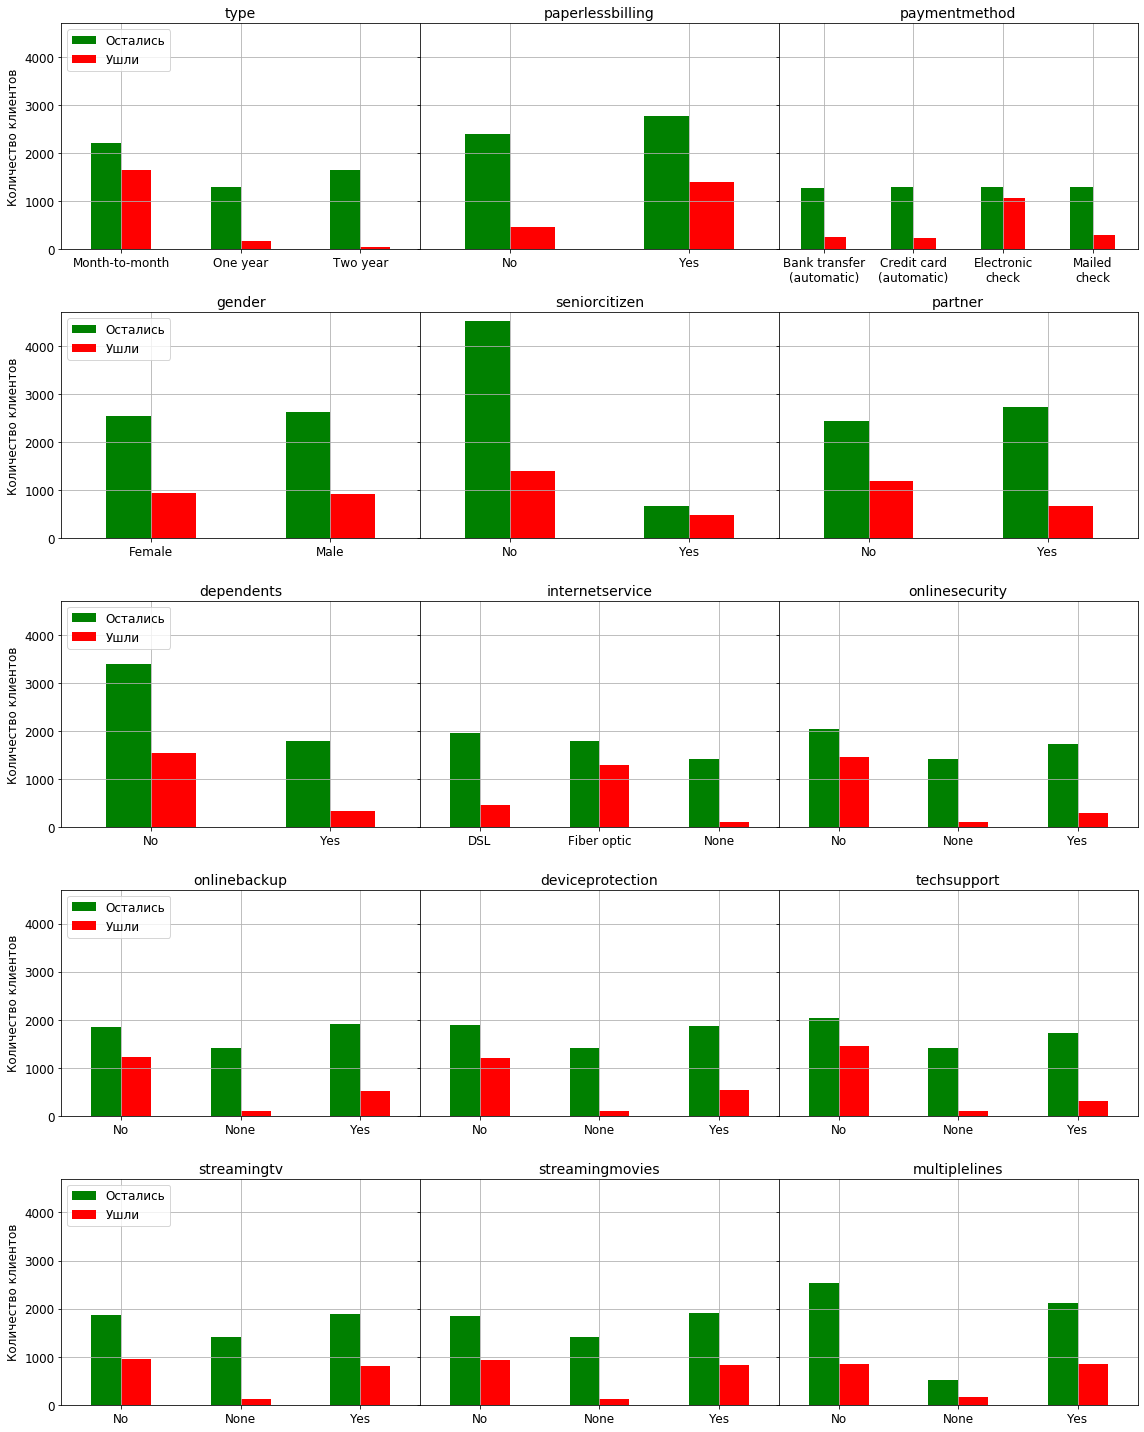

In [14]:
categorical = list(df.select_dtypes(include=['object']).columns)
print(35 * ' ' + 'Соотношение ушедших и оставшихся клиентов по категориям')
fig, ax = plt.subplots(nrows=5, ncols=3)
fig.set_size_inches(16, 20)

for i, x in enumerate(categorical):
    pivot = df.pivot_table(index='churn', values='monthlycharges', columns=x, aggfunc='count')
    row = i // 3
    col = i % 3
    pivot.transpose().plot.bar(ax=ax[row][col], rot=0, grid=True, color=['green', 'red'])
    ax[row][col].set_xlabel('')    
    ax[row][col].set_title(x, fontsize=14)
    ax[row][col].set_yticks(np.arange(0, 4501, 1000))
    ax[row][col].set_ylim(0, 4700)
    ax[row][col].tick_params(labelsize=12)
    if col == 0:
        ax[row][col].set_ylabel('Количество клиентов', fontsize=12)
        ax[row][col].legend(['Остались', 'Ушли'], loc='upper left', fontsize=12)
    else:
        ax[row][col].set_ylabel('')
        ax[row][col].set_yticklabels('')
        ax[row][col].get_legend().remove()
    if x == 'paymentmethod':
        ax[row][col].set_xticklabels(['Bank transfer\n(automatic)', 'Credit card\n(automatic)', 
                                      'Electronic\ncheck', 'Mailed\ncheck'])
plt.tight_layout()
plt.subplots_adjust(wspace=0)

* Чем длиннее период оплаты, тем меньше доля ушедших клиентов. Наибольший отток наблюдается среди пользователей, использующих помесячную оплату.
* Клиенты, использующие безбумажный способ выставления счёта и метод оплаты электронным чеком, более склонны к уходу.
* Отток не зависит от пола.
* Процент людей, отказавшихся от услуг компании, выше среди пенсионеров, а также людей без супруга/супруги и членов семьи на обеспечении.
* Клиенты, использующие только стационарную телефонную связь, уходят гораздо реже, чем клиенты, использующие только интернет.
* Процент оттока среди пользователей интернета с подключением через оптоволоконный кабель более высокий по сравнению с аналогичным показателем у пользователей с подключением через телефонную линию.
* Пенсионеры и люди без стационарного телефона составляют малую часть клиентов.
* Подключение телефонного аппарата к нескольким линиям не является существенным.
* Клиенты, не использующие дополнительные интернет-услуги, более склонны к уходу. Наименее сильно это проявляется в отношении стриминговых сервисов.

Так как соотношения ушедших и оставшихся клиентов по категориям дополнительных интернет-услуг похожи, создадим новый признак, показывающий их количество, и исследуем отток.

In [15]:
additional_services = df.iloc[:, 10:16].columns

def services(row):
    n=0
    for i in additional_services:
        if row[i]=='Yes':
            n+=1
        if row[i]=='None':
            n=-1
    return n

df['services'] = df.apply(services, axis=1)

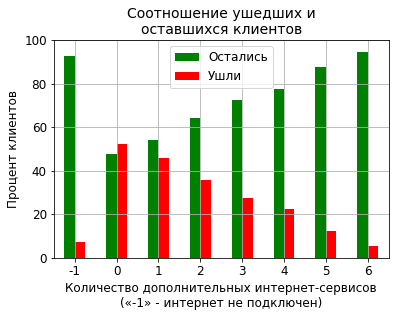

In [16]:
pivot = df.pivot_table(index='churn', values='monthlycharges', columns='services', aggfunc='count')
for i in pivot.columns:
    pivot[i] = pivot[i] * 100 / pivot[i].sum()
fig, ax = plt.subplots()
fig.set_size_inches(6, 4)
pivot.transpose().plot.bar(ax=ax, rot=0, grid=True, color=['green', 'red'])
ax.set_title('Соотношение ушедших и\nоставшихся клиентов', fontsize=14)
ax.legend(['Остались', 'Ушли'], loc='upper center', fontsize=12)
ax.set_xlabel('Количество дополнительных интернет-сервисов\n(«-1» - интернет не подключен)', fontsize=12)
ax.set_ylabel('Процент клиентов', fontsize=12)
ax.set_yticks(np.arange(0, 101, 20))
ax.set_ylim(0, 100)
ax.tick_params(labelsize=12)

По графику видна чёткая зависимость — чем больше дополнительных интернет-сервисов подключено у человека, тем менее он склонен к уходу.

Исследуем количественные признаки.

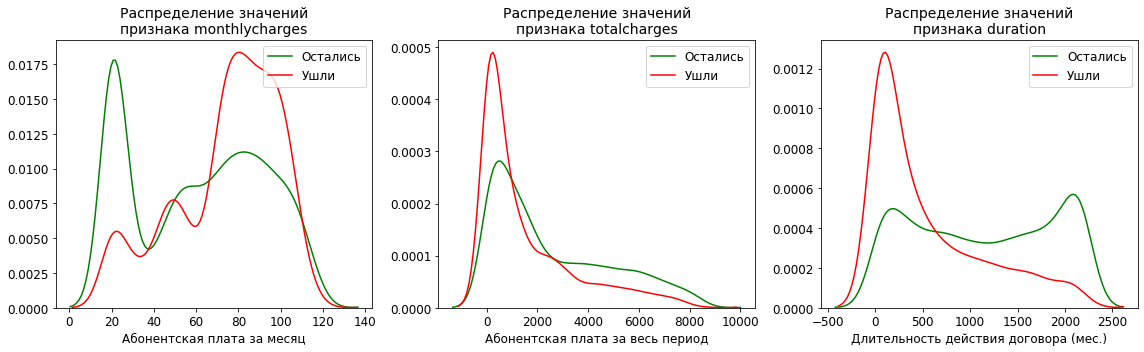

In [17]:
numerical = {'monthlycharges':'Абонентская плата за месяц',
             'totalcharges':'Абонентская плата за весь период',
             'duration':'Длительность действия договора (мес.)'}
fig, ax = plt.subplots(ncols=3)
fig.set_size_inches(16, 5)
for i, x in enumerate(numerical.keys()):
    sns.kdeplot(df.loc[df['churn']==0, x], ax=ax[i], color='g', label='Остались')
    sns.kdeplot(df.loc[df['churn']==1, x], ax=ax[i], color='r', label='Ушли')
    ax[i].set_title('Распределение значений\nпризнака ' + x, fontsize=14)
    ax[i].legend(loc='upper right', fontsize=12)
    ax[i].set_xlabel(numerical[x], fontsize=12)
    ax[i].tick_params(labelsize=12)
    
plt.tight_layout()

На основе графиков распределения значений признаков *monthlycharges* и *duration* можно сделать вывод, что чаще всего от услуг компании отказываются клиенты с высокой месячной абонентской платой, а также те, кто подключился недавно. График распределения значений абонентской платы за весь период является производным от двух предыдущих. Убедимся в этом, рассчитав коэффициент корреляции Пирсона.

In [18]:
numerical = list(numerical.keys())
df[numerical].corr()

,monthlycharges,totalcharges,duration
monthlycharges,1.000000,0.651174,0.247754
totalcharges,0.651174,1.000000,0.826109
duration,0.247754,0.826109,1.000000


Как и предполагалось, признак *totalcharges* довольно сильно коррелирует с признаками *duration* и *monthlycharges*, поэтому в дальнейшем его лучше удалить, чтобы избежать мультиколлинеарности.

Исследуем баланс классов целевого признака.

In [19]:
round(df['churn'].value_counts() / len(df), 2)

0    0.73
1    0.27
Name: churn, dtype: float64

В датасете присутствует дисбаланс классов целевого признака: объектов нулевого класса почти в 3 раза больше, чем объектов единичного.

#### Вывод

В ходе исследовательского анализа данных удалось установить, что, вероятнее всего, наиболее важными признаками для предсказания оттока клиентов являются: длительность действия договора, месячная абонентская плата, количество дополнительных интернет-услуг, а также периодичность и метод оплаты. Соотношение классов целевого признака составляет 73 к 27.

### 3. Построение модели

Сбросим индексы датафрейма и удалим лишние признаки с информацией о подключении конкретных интернет-услуг (т.к. созданный количественный признак *services* лучше отражает зависимость), о поле клиентов (т.к. он не оказывает влияния на склонность людей к уходу) и о полной абонентской плате (чтобы избежать мультиколлинеарности).

In [20]:
df.reset_index(drop=True, inplace=True)
df.drop(list(additional_services) + ['gender', 'totalcharges'], axis=1, inplace=True)

Закодируем признаки методом порядкового кодирования.

In [21]:
for i in list(additional_services) + ['gender']:
    categorical.remove(i)
    
encoder = OrdinalEncoder()
df_ordinal = df.copy()
df_ordinal[categorical] = encoder.fit_transform(df[categorical])

df_ordinal.sample(5)

,type,paperlessbilling,paymentmethod,monthlycharges,seniorcitizen,partner,dependents,internetservice,multiplelines,churn,duration,services
2865,2.0,0.0,0.0,109.25,0.0,1.0,1.0,1.0,2.0,0,2011,5
7041,0.0,1.0,3.0,74.40,1.0,1.0,0.0,1.0,2.0,1,124,0
2003,2.0,1.0,2.0,95.25,0.0,0.0,0.0,1.0,0.0,1,1735,3
2046,0.0,0.0,3.0,24.70,0.0,0.0,1.0,0.0,1.0,0,32,0
6048,0.0,1.0,2.0,94.45,1.0,1.0,0.0,1.0,2.0,1,884,2


Разделим датасет на тренировочную и тестовую выборки.

In [22]:
features = df_ordinal.drop('churn', axis=1)
target = df_ordinal['churn']

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=5)

print(' ' * 11 + '{:<12} {:<11}'.format('features', 'target'))
print('Обучающая: {:<12} {:<15}'.format(str(features_train.shape),
                                        str(target_train.shape)))
print('Тестовая:  {:<12} {:<15}'.format(str(features_test.shape),
                                        str(target_test.shape)))

           features     target     
Обучающая: (5634, 11)   (5634,)        
Тестовая:  (1409, 11)   (1409,)        


Обучим по сетке с различными гиперпараметрами модели логистической регрессии и градиентного бустинга на основе библиотек *XGBoost*, *LightGBM*, *CatBoost*.

In [23]:
model = LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear', random_state=5)
parameters = {'C': np.logspace(-3, 3, 7), 
              'penalty': ['l1', 'l2']}
lr_grid = GridSearchCV(model, parameters, cv=4, n_jobs=-1, scoring='roc_auc')
lr_grid.fit(features_train, target_train)

print('Логистическая регрессия')
print('Лучшие гиперпараметры: ', lr_grid.best_params_)
print('AUC-ROC = {:.4f}'.format(lr_grid.best_score_))

Логистическая регрессия
Лучшие гиперпараметры:  {'C': 1000.0, 'penalty': 'l2'}
AUC-ROC = 0.8343


In [24]:
ne = np.arange(100, 1001, 100)
lr = np.logspace(-2, -0.15, 30)
md = np.arange(2, 4)

warn.filterwarnings('ignore')

model = XGBClassifier(scale_pos_weight=73/27, verbosity=0, random_state=5)
parameters = {'n_estimators': ne,
              'learning_rate': lr,
              'max_depth': md}
xgb_grid = GridSearchCV(model, parameters, cv=4, n_jobs=-1, scoring='roc_auc')
xgb_grid.fit(features_train, target_train)

warn.filterwarnings('default')

print('XGBoost')
print('Лучшие гиперпараметры: ', xgb_grid.best_params_)
print('AUC-ROC = {:.4f}'.format(xgb_grid.best_score_))

XGBoost
Лучшие гиперпараметры:  {'learning_rate': 0.29325226779444347, 'max_depth': 2, 'n_estimators': 1000}
AUC-ROC = 0.9248


In [25]:
model = LGBMClassifier(scale_pos_weight=73/27, random_state=5)
parameters = {'n_estimators': ne,
              'learning_rate': lr,
              'num_leaves': np.arange(2, 11)}
lgbm_grid = GridSearchCV(model, parameters, cv=4, n_jobs=-1, scoring='roc_auc')
lgbm_grid.fit(features_train, target_train)

print('LightGBM')
print('Лучшие гиперпараметры: ', lgbm_grid.best_params_)
print('AUC-ROC = {:.4f}'.format(lgbm_grid.best_score_))

LightGBM
Лучшие гиперпараметры:  {'learning_rate': 0.4556387897733956, 'n_estimators': 700, 'num_leaves': 3}
AUC-ROC = 0.9206


In [26]:
model = CatBoostClassifier(scale_pos_weight=73/27, verbose=0, random_state=5)
parameters = {'iterations': ne,
              'learning_rate': lr,
              'depth':  md}
cb_grid = GridSearchCV(model, parameters, cv=4, n_jobs=-1, scoring='roc_auc')
cb_grid.fit(features_train, target_train)

print('CatBoost')
print('Лучшие гиперпараметры: ', cb_grid.best_params_)
print('AUC-ROC = {:.4f}'.format(cb_grid.best_score_))

CatBoost
Лучшие гиперпараметры:  {'depth': 2, 'iterations': 400, 'learning_rate': 0.5277324421725116}
AUC-ROC = 0.9363


Логистическая регрессия показала худшее значение метрики AUC-ROC. Результаты алгоритмов из семейства градиентного бустинга близки друг к другу. Исследуем их более подробно.

In [27]:
grids = {'XGBoost': xgb_grid,
         'LightGBM': lgbm_grid,
         'CatBoost': cb_grid}

results = grids.copy()
for i in grids.keys():
    results[i] = abs(round(pd.DataFrame(grids[i].cv_results_)
                           .iloc[:, [4, 5, 6, 0, 2, 12]]
                           .sort_values('mean_test_score', ascending=False)
                           .head(5), 4))
    print(i)
    display(results[i])

XGBoost


,param_learning_rate,param_max_depth,param_n_estimators,mean_fit_time,mean_score_time,mean_test_score
469,0.293252,2,1000,3.3539,0.0092,0.9248
467,0.293252,2,800,2.7034,0.009,0.9246
468,0.293252,2,900,3.0153,0.0082,0.9246
429,0.218603,2,1000,3.4034,0.0092,0.9242
489,0.339652,2,1000,3.4086,0.0085,0.9238


LightGBM


,param_learning_rate,param_n_estimators,param_num_leaves,mean_fit_time,mean_score_time,mean_test_score
2395,0.455639,700,3,0.9307,0.012,0.9206
2476,0.527732,600,3,0.7897,0.0122,0.9204
2386,0.455639,600,3,0.88,0.0107,0.9204
2467,0.527732,500,3,0.694,0.0107,0.9202
2413,0.455639,900,3,1.2218,0.0132,0.9201


CatBoost


,param_depth,param_iterations,param_learning_rate,mean_fit_time,mean_score_time,mean_test_score
117,2,400,0.527732,6.0875,0.0682,0.9363
175,2,600,0.393394,7.7512,0.0952,0.9355
87,2,300,0.527732,4.1481,0.0875,0.9355
147,2,500,0.527732,6.2792,0.0732,0.9355
116,2,400,0.455639,5.0823,0.0735,0.9353


Из полученных таблиц видно, что качество моделей *CatBoost* самое высокое, при этом они работают немного медленнее других алгоритомов. Модели *LightGBM* показывают худшее среди трёх рассматриваемых алгоритмов качество, а также лучшую скорость обучения. Модели *XGBoost* демонстрируют средние показатели. Исходя из этого, в качестве финальной модели выберем модель градиентного бустинга, основанную на библиотеке *CatBoost*, с глубиной, равной 2, learning rate, равным 0.53, и числом итераций, равным 400, AUC-ROC которой на кросс-валидации составил 0.9363.

### 4. Тестирование модели

Обучим финальную модель на всей тренировочной выборке и проверим качество её предсказаний на тестовой выборке.

AUC-ROC = 0.9370
Accuracy = 0.8751
Полнота = 0.8290
Точность = 0.7442


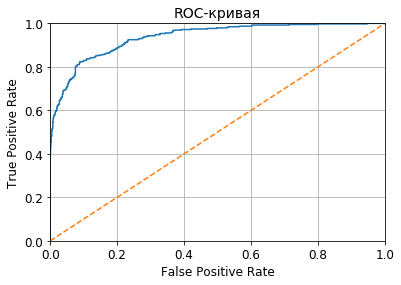

In [28]:
model_final = CatBoostClassifier(iterations=400, depth=2, learning_rate=0.53,
                                 scale_pos_weight=73/27, verbose=0, random_state=5)


model_final.fit(features_train, target_train)
predictions = model_final.predict(features_test)
probabilities = model_final.predict_proba(features_test)
probabilities_one = probabilities[:, 1]

print('AUC-ROC = {:.4f}'.format(roc_auc_score(target_test, probabilities_one)))
print('Accuracy = {:.4f}'.format(accuracy_score(target_test, predictions)))
print('Полнота = {:.4f}'.format(recall_score(target_test, predictions)))
print('Точность = {:.4f}'.format(precision_score(target_test, predictions)))

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one)

fig, ax = plt.subplots()
fig.set_size_inches(6, 4)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
ax.set_title('ROC-кривая', fontsize=14)
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.grid(True)
ax.tick_params(labelsize=12)

Выбранная модель градиентного бустинга, основанная на библиотеке *CatBoost*, подтвердила своё качество на тестовой выборке, достигнув значения AUC-ROC 0.937. При этом результат оказался чуть выше, чем на валидации, что говорит об отсутствии переобучения. Метрика *accuracy* составила 0.8751. Полученные значения полноты и точности говорят о том, что модель хорошо справляется с выявлением оттока среди реально ушедших клиентов (82.9%), при этом доля истинно положительных ответов от общего числа предсказанных уходов составляет 74.42%.

### 5. Вывод

В ходе выполнения проекта данные были объединены в одну таблицу, прошли предварительную обработку и были проанализированы. В результате этого создано несколько новых признаков (длительность действия договора в днях, количество дополнительных интернет-услуг и целевой признак, определяющий уход пользователя) и удалена часть имеющихся,  которые были признаны несущественными, либо избыточными для предсказания оттока клиентов. Выявлен дисбаланс классов целевого признака: 73 к 27. Признаки подготовлены к обучению. На полученных данных обучены модели логистической регрессии и градиентного бустинга на основе библиотек *XGBoost*, *LightGBM*, *CatBoost* с различными гиперпараметрами. Установлено, что модель логистической регрессии уступает в качестве моделям из семейства градиентного бустинга. Модели *CatBoost* дают более высокое качество предсказаний, чем *XGBoost* и *LightGBM*, однако работают медленнее. Основные показатели лучшей модели каждого алгоритма по итогам кросс-валидации представлены в таблице.

In [29]:
lr_results = round(pd.DataFrame(lr_grid.cv_results_)
                   .sort_values('mean_test_score', ascending=False)
                   .head(1)[['mean_fit_time', 'mean_test_score']], 4)

pd.DataFrame({'AUC-ROC': [lr_results.iloc[0, 1],
                          results['XGBoost'].iloc[0, 5],
                          results['LightGBM'].iloc[0, 5],
                          results['CatBoost'].iloc[0, 5]],
              'Время обучения': [lr_results.iloc[0, 0],
                                 results['XGBoost'].iloc[0, 3],
                                 results['LightGBM'].iloc[0, 3],
                                 results['CatBoost'].iloc[0, 3]]},
             index=['Логистическая регрессия', 'XGBoost', 'LightGBM', 'CatBoost'])

,AUC-ROC,Время обучения
Логистическая регрессия,0.8343,0.0252
XGBoost,0.9248,3.3539
LightGBM,0.9206,0.9307
CatBoost,0.9363,6.0875


Так как в задаче не указаны ограничения по времени обучения, в качестве финальной выбрана модель *CatBoost*, продемонстрировавшая наиболее высокое качество предсказаний. Гиперпараметры финальной модели:

* iterations = 400;
* depth = 2;
* learning_rate = 0.53;
* scale_pos_weight = 73/27.

По результатам тестирования финальная модель подтвердила своё качество, достигнув следующих значений метрик:

* AUC-ROC = 0.937;
* Accuracy = 0.8751;
* Recall = 0.829;
* Precision = 0.7442.

Самым важным признаком для предсказания оттока клиентов оказалось время действия договора (*duration*). Следующими по важности являются периодичность оплаты (*type*) и размер месячной абонентской платы (*monthlycharges*).

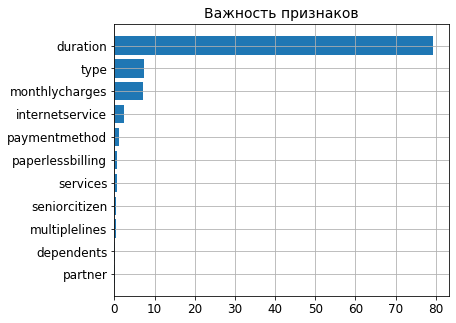

In [30]:
importance = pd.Series(model_final.feature_importances_, index=features_train.columns).sort_values()

fig, ax = plt.subplots()
fig.set_size_inches(6, 5)
plt.barh(importance.index, importance)
ax.set_title('Важность признаков', fontsize=14)
ax.grid(True)
ax.tick_params(labelsize=12)